In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.5'

In [ ]:
import tensorflow as tf
tf.VERSION

In [ ]:
from platform import python_version
print(python_version())

# Start here

In [1]:
import pandas as pd
import numpy as np

import datetime
import pytz
import requests
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/5y'

djia_tickers = [
    'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
    'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
    'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

In [3]:
def get_dataframe_from_ticker(ticker_symbol):
    r = requests.get(url = IEX_API_URL_TEMPLATE.format(ticker_symbol.lower()))
    df = json_normalize(r.json())

    df.insert(loc=0, column='symbol', value=ticker_symbol)

    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['timestamp'] = df.date.values.astype(np.int64)

    df = df.drop(['label',
                  'change', 'changeOverTime', 'changePercent',
                  'high', 'low', 'open',
                  'unadjustedVolume', 'volume', 'vwap'],
                 axis=1)

    return df

### POC 01

In [4]:
aapl_hist = get_dataframe_from_ticker('AAPL')
aapl_hist.dtypes

symbol               object
close               float64
date         datetime64[ns]
year                  int64
month                 int64
day                   int64
week                  int64
dayofweek             int64
dayofyear             int64
timestamp             int64
dtype: object

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


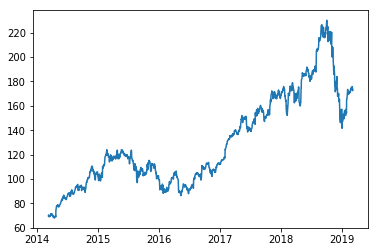

In [5]:
#aapl_hist = djia.query("symbol=='AAPL' and date >= '2018-01-01'")
#aapl_hist.index = aapl_hist.date
#plt.plot(aapl_hist.date, aapl_hist.close, label='Close Price history')
plt.plot(aapl_hist.date, aapl_hist.close, label='Close Price history')

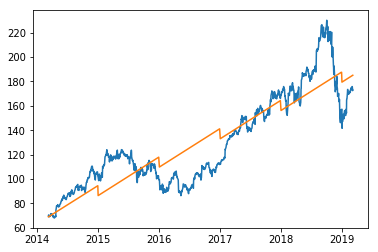

In [6]:
from sklearn.linear_model import LinearRegression

x = aapl_hist.drop(['symbol', 'date', 'close'], axis=1)
y = aapl_hist.close

model = LinearRegression()
model.fit(x, y)

preds = model.predict(x)

#rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
#rms

#plt.plot(aapl_hist.close, preds)

plt.plot(aapl_hist.date, aapl_hist.close, label='Close Price history')
plt.plot(aapl_hist.date, preds, label='Prediction')

### ---------------------------

In [7]:
from pyramid.arima import auto_arima

/usr/local/lib/python3.5/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [8]:
from fbprophet import Prophet

In [9]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


Using TensorFlow backend.


### ---------------------------------

In [ ]:
def get_djia_dataframe():
    djia = None

    for t in djia_tickers:
        r = requests.get(url = IEX_API_URL_TEMPLATE.format(t.lower()))
        df = json_normalize(r.json())
        df.insert(loc=0, column='symbol', value=t)

        if djia is None:
            djia = df
        else:
            djia = djia.append(df)

    djia.date = pd.to_datetime(df.date, format='%Y-%m-%d')

    return djia


In [ ]:
djia = get_djia_dataframe()

In [ ]:
djia

In [ ]:
djia.to_pickle('djia_' + datetime.datetime.now(pytz.timezone('US/Pacific')).strftime('%Y-%m-%d') + '.pkl')

In [ ]:
djia.dtypes

In [ ]:
poc_djia = djia.query("symbol=='AAPL' and date >= '2018-01-01'")
poc_djia.index = poc_djia.date

In [ ]:
plt.plot(poc_djia.close, label='Close Price history')

In [ ]:
init_date = min(poc_djia.date)
last_date = max(poc_djia.date)
part_date = last_date - datetime.timedelta(days=28)
print('{} {} -- {}'.format(init_date, last_date, part_date))

In [ ]:
print(last_date - datetime.timedelta(days=28))

In [ ]:
train = poc_djia.query("date <= '{}'".format(part_date))
train.index = train.date
plt.plot(train.close, label='Close Price history')

In [ ]:
valid = poc_djia.query("date > '{}'".format(part_date))
valid.index = valid.date
plt.plot(valid.close, label='Close Price history')

In [ ]:
plt.plot(train.close)
plt.plot(valid.close)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#x_train = train.drop('close', axis=1)
x_train = train[['date']]
#x_train.index = x_train.date
y_train = train.close
#x_valid = valid.drop('close', axis=1)
x_valid = valid.date
#x_valid.index = x_valid.date
y_valid = valid.close

model = LinearRegression()
model.fit(x_train, y_train)

preds = model.predict(x_valid)

#rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
#rms

plt.plot(train.close)
plt.plot(valid.close, preds)